In [78]:
#----------------------------------------------------------------------------------------------------------------------------------
# training of a boosting model on loan data to predict target => loan status (1 <> 0): 
# 0: non-default
# 1: credit default

# data has already been cleaned and preprocessed
#----------------------------------------------------------------------------------------------------------------------------------

In [80]:
# importing all required packages / modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

In [159]:
# load data
data=pd.read_csv("cr_loan_preprocessed.csv")
print(data["loan_status"].value_counts(normalize=True))
data.head()

loan_status
0    0.78061
1    0.21939
Name: proportion, dtype: float64


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,21,9600,5,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
1,25,9600,1,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
2,23,65500,4,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
3,24,54400,8,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1
4,21,9900,2,2500,7.14,1,0.25,2,0,0,...,1,1,0,0,0,0,0,0,1,0


In [83]:
# defining X,y and splitting into training and test data
X=data.drop("loan_status",axis=1)
y=data["loan_status"]
y.value_counts()

X_train, X_test, y_train, y_test=train_test_split(X,y,stratify=y,random_state=87)

In [152]:
# training model and predict probabilities and target values
clf_gbt = xgb.XGBClassifier(n_estimators=60).fit(X_train, y_train)
gbt_proba = clf_gbt.predict_proba(X_test)
print(f"class order in probabilities array: {clf_gbt.classes_}")
gbt_preds = clf_gbt.predict(X_test)

class order in probabilities array: [0 1]


In [153]:
# model evalutaion
score=classification_report(y_test, gbt_preds, target_names=['Non-Default', 'Default'],output_dict=True)
if score["macro avg"]["f1-score"] > 0.85:
    print(f"Model is accepted: Macro Avg F1 Score -> {score["macro avg"]["f1-score"]:.2f}.")
else:
    print(f"Model is not accepted: Macro Avg F1 Score -> {score["macro avg"]["f1-score"]:.2f}.")

Model is accepted: Macro Avg F1 Score -> 0.90.


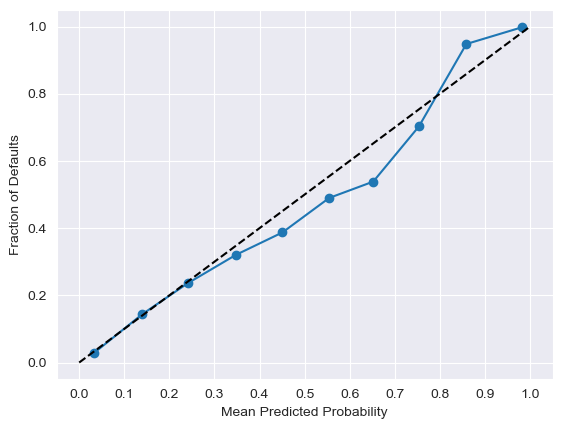

In [154]:
# setting up a calibration curve to further assess model performance
prob_true, prob_pred = calibration_curve(y_test, gbt_proba[:,1], n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Defaults')
plt.grid(True)
plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.show()

In [168]:
if brier_score_loss(y_test, gbt_proba[:,1]) < 0.1:
    print("Calibration is accepted.")

Calibration is accepted.


In [94]:
# calculating expected loss based on predicted probabilities
portfolio = pd.DataFrame({
    "default_prob": gbt_proba[:, 1],
    "loan_amount": X_test["loan_amnt"].values,
    "loss_given_default": np.repeat(0.2,len(X_test))
})
portfolio.head()

In [163]:
portfolio["expected_loss"] = portfolio["default_prob"] * portfolio["loan_amount"] * portfolio["loss_given_default"]
print(f"Expected loss: {np.sum(portfolio["expected_loss"])/1000000:.2f} million €.")

Expected loss: 3.46 million €.


In [179]:
# computing threshold for different loan acceptance rates (i.e. accept 70% of all loans) and corresponding total value
acceptance_rates=np.arange(0.5, 0.95, 0.05)
thresholds=[]
bad_rates=[]
thresh_eva=pd.DataFrame({"default_probs" : gbt_proba[:,1],
                        "true_loan_status" : y_test})

for rate in acceptance_rates:
    threshold=round(np.quantile(gbt_proba[:,1],rate),2)
    thresholds.append(threshold)
    thresh_eva["loan_status"]=thresh_eva["default_probs"].apply(lambda x: 1 if x>threshold else 0)
    accepted_loans=thresh_eva[thresh_eva["loan_status"]==0]
    bad_rate=np.sum(accepted_loans["true_loan_status"])/accepted_loans["true_loan_status"].count()
    bad_rates.append(bad_rate)

df=pd.DataFrame(zip(acceptance_rates,thresholds,bad_rates),columns=["acceptance_rates","thresholds","bad_rates"]).sort_values("acceptance_rates",ascending=False)

number_total_loans=len(data)
df["number_accepted_loans"]=df["acceptance_rates"]*number_total_loans
df["average_loan_amnt"]=data["loan_amnt"].mean()
df["total_value"]=round(((1-df["bad_rates"])*df["number_accepted_loans"]*df["average_loan_amnt"])-(df["bad_rates"]*df["number_accepted_loans"]*df["average_loan_amnt"]),0)
df

,acceptance_rates,thresholds,bad_rates,number_accepted_loans,average_loan_amnt,total_value
8,0.90,0.98,0.130389,26513.10,9583.600937,187829764.0
7,0.85,0.85,0.082122,25040.15,9583.600937,200560506.0
6,0.80,0.29,0.058514,23567.20,9583.600937,199426744.0
5,0.75,0.19,0.046844,22094.25,9583.600937,191904782.0
4,0.70,0.14,0.038132,20621.30,9583.600937,182554420.0
3,0.65,0.11,0.030604,19148.35,9583.600937,172277992.0
2,0.60,0.09,0.023669,17675.40,9583.600937,161375330.0
1,0.55,0.07,0.018434,16202.45,9583.600937,149552926.0
0,0.50,0.06,0.016120,14729.50,9583.600937,136610537.0


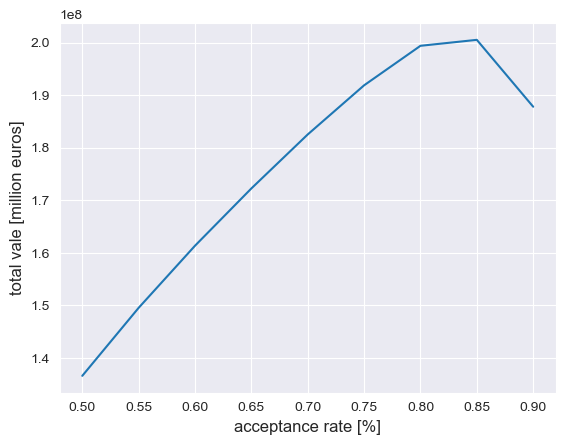

In [194]:
# determing acceptance rate with max. total value
sns.set_style("darkgrid")
sns.lineplot(data=df, y=df["total_value"], x=df["acceptance_rates"])
plt.xlabel("acceptance rate [%]",fontsize="large")
plt.ylabel(f"total vale [million euros]",fontsize="large")
plt.show()

In [192]:
max_value = df[df["total_value"] == df["total_value"].max()]
max_value
print(f"The highest total value of {max_value.iloc[0]["total_value"]/1000000:.2f} million euros is reached at a loan acceptance rate of {max_value.iloc[0]["acceptance_rates"]:.2f}%.")

The highest total value of 200.56 million euros is reached at a loan acceptance rate of 0.85%.
